# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

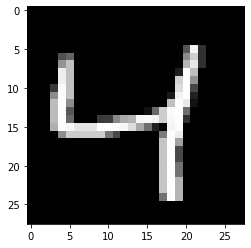

In [4]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

### 入力データは、Flatten済み

In [5]:
print( mnist.train.images.shape ) 
print( mnist.train.images.shape[1] ) 

(60000, 784)
784


In [6]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 32 # feel free to change this value

image_size = mnist.train.images.shape[1]

# Input and target placeholders
inputs_  = tf.placeholder( tf.float32, [None, image_size] , name = 'inputs' ) 
targets_ = tf.placeholder( tf.float32, [None, image_size] , name = 'targets' ) 

# Output of hidden layer, single fully connected layer here with ReLU activation
encoded = tf.layers.dense(inputs_, encoding_dim, activation=tf.nn.relu)

# Output layer logits, fully connected layer with no activation
logits =  tf.layers.dense( encoded, image_size, activation=None)

# Sigmoid output from logits
decoded = tf.nn.sigmoid( logits, name = 'output')

# Sigmoid cross-entropy loss
# sigmoid_cross_entropy_with_logits　が　中で sigmoid()をするので
# sigmoid()済みの decoded　ではなく、 logits　を入力する
loss = tf.nn.sigmoid_cross_entropy_with_logits( labels=targets_, logits=logits )

# Mean of the loss
cost = tf.reduce_mean( loss )

# Adam optimizer
opt  = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

In [7]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [9]:
batch = mnist.train.next_batch(200)
print( batch[0] )
print( "-------------------" )
print( batch[1] )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-------------------
[6 4 9 0 6 2 7 0 4 5 1 6 1 2 5 3 0 1 8 0 2 7 2 3 1 5 4 8 6 6 1 5 8 1 7 8 1
 0 8 5 5 1 4 9 2 7 5 2 4 1 9 9 6 7 0 1 6 6 9 7 4 9 9 9 9 0 9 2 3 3 2 2 2 8
 5 4 5 2 4 2 7 7 5 2 0 4 0 2 2 7 8 7 7 8 7 9 9 4 7 1 5 8 9 5 8 3 2 7 2 9 8
 4 2 7 6 1 3 9 6 0 0 1 4 3 9 1 3 5 1 1 2 5 2 7 0 4 1 6 6 5 1 3 2 0 5 7 5 0
 5 7 7 2 4 3 2 1 5 1 7 0 7 0 8 8 0 8 0 3 7 2 7 2 7 3 8 5 8 4 0 2 3 8 4 7 5
 7 9 3 6 8 4 1 3 5 2 5 8 6 2 9]


In [7]:
epochs     = 20
batch_size = 200

# 重みの初期化
sess.run(tf.global_variables_initializer())

# エポック毎のループ
for e in range(epochs):
    # バッチごとのループ
    for ii in range(mnist.train.num_examples//batch_size):
        
        # batch = (images , labels)
        batch = mnist.train.next_batch(batch_size)
        
        # 今回は、Encoderなので、入力と出力が同じことを想定している。
        # それ故、inputs_　と　targets_　に、同じものを入力する
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6949
Epoch: 1/20... Training loss: 0.6910
Epoch: 1/20... Training loss: 0.6872
Epoch: 1/20... Training loss: 0.6827
Epoch: 1/20... Training loss: 0.6779
Epoch: 1/20... Training loss: 0.6720
Epoch: 1/20... Training loss: 0.6648
Epoch: 1/20... Training loss: 0.6565
Epoch: 1/20... Training loss: 0.6482
Epoch: 1/20... Training loss: 0.6353
Epoch: 1/20... Training loss: 0.6247
Epoch: 1/20... Training loss: 0.6136
Epoch: 1/20... Training loss: 0.5980
Epoch: 1/20... Training loss: 0.5836
Epoch: 1/20... Training loss: 0.5688
Epoch: 1/20... Training loss: 0.5509
Epoch: 1/20... Training loss: 0.5313
Epoch: 1/20... Training loss: 0.5116
Epoch: 1/20... Training loss: 0.4944
Epoch: 1/20... Training loss: 0.4775
Epoch: 1/20... Training loss: 0.4605
Epoch: 1/20... Training loss: 0.4438
Epoch: 1/20... Training loss: 0.4272
Epoch: 1/20... Training loss: 0.4156
Epoch: 1/20... Training loss: 0.3992
Epoch: 1/20... Training loss: 0.3791
Epoch: 1/20... Training loss: 0.3695
E

Epoch: 1/20... Training loss: 0.1933
Epoch: 1/20... Training loss: 0.1926
Epoch: 1/20... Training loss: 0.1963
Epoch: 1/20... Training loss: 0.1946
Epoch: 1/20... Training loss: 0.1979
Epoch: 1/20... Training loss: 0.1951
Epoch: 1/20... Training loss: 0.1926
Epoch: 1/20... Training loss: 0.1912
Epoch: 1/20... Training loss: 0.1930
Epoch: 1/20... Training loss: 0.1943
Epoch: 1/20... Training loss: 0.1901
Epoch: 1/20... Training loss: 0.1865
Epoch: 1/20... Training loss: 0.1882
Epoch: 1/20... Training loss: 0.1883
Epoch: 1/20... Training loss: 0.1967
Epoch: 1/20... Training loss: 0.1881
Epoch: 1/20... Training loss: 0.1963
Epoch: 1/20... Training loss: 0.1895
Epoch: 1/20... Training loss: 0.1895
Epoch: 1/20... Training loss: 0.1927
Epoch: 1/20... Training loss: 0.1871
Epoch: 1/20... Training loss: 0.1948
Epoch: 1/20... Training loss: 0.1887
Epoch: 1/20... Training loss: 0.1866
Epoch: 1/20... Training loss: 0.1921
Epoch: 1/20... Training loss: 0.1906
Epoch: 1/20... Training loss: 0.1969
E

Epoch: 2/20... Training loss: 0.1469
Epoch: 2/20... Training loss: 0.1457
Epoch: 2/20... Training loss: 0.1550
Epoch: 2/20... Training loss: 0.1477
Epoch: 2/20... Training loss: 0.1473
Epoch: 2/20... Training loss: 0.1481
Epoch: 2/20... Training loss: 0.1472
Epoch: 2/20... Training loss: 0.1470
Epoch: 2/20... Training loss: 0.1550
Epoch: 2/20... Training loss: 0.1496
Epoch: 2/20... Training loss: 0.1526
Epoch: 2/20... Training loss: 0.1376
Epoch: 2/20... Training loss: 0.1461
Epoch: 2/20... Training loss: 0.1444
Epoch: 2/20... Training loss: 0.1492
Epoch: 2/20... Training loss: 0.1463
Epoch: 2/20... Training loss: 0.1486
Epoch: 2/20... Training loss: 0.1523
Epoch: 2/20... Training loss: 0.1482
Epoch: 2/20... Training loss: 0.1509
Epoch: 2/20... Training loss: 0.1486
Epoch: 2/20... Training loss: 0.1414
Epoch: 2/20... Training loss: 0.1487
Epoch: 2/20... Training loss: 0.1473
Epoch: 2/20... Training loss: 0.1478
Epoch: 2/20... Training loss: 0.1547
Epoch: 2/20... Training loss: 0.1481
E

Epoch: 3/20... Training loss: 0.1276
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1316
Epoch: 3/20... Training loss: 0.1261
Epoch: 3/20... Training loss: 0.1304
Epoch: 3/20... Training loss: 0.1298
Epoch: 3/20... Training loss: 0.1266
Epoch: 3/20... Training loss: 0.1297
Epoch: 3/20... Training loss: 0.1284
Epoch: 3/20... Training loss: 0.1319
Epoch: 3/20... Training loss: 0.1315
Epoch: 3/20... Training loss: 0.1306
Epoch: 3/20... Training loss: 0.1274
Epoch: 3/20... Training loss: 0.1284
Epoch: 3/20... Training loss: 0.1324
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1289
Epoch: 3/20... Training loss: 0.1267
Epoch: 3/20... Training loss: 0.1297
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1268
Epoch: 3/20... Training loss: 0.1335
Epoch: 3/20... Training loss: 0.1333
Epoch: 3/20... Training loss: 0.1290
Epoch: 3/20... Training loss: 0.1251
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1253
E

Epoch: 4/20... Training loss: 0.1142
Epoch: 4/20... Training loss: 0.1156
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1175
Epoch: 4/20... Training loss: 0.1116
Epoch: 4/20... Training loss: 0.1188
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1159
Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1162
Epoch: 4/20... Training loss: 0.1125
Epoch: 4/20... Training loss: 0.1157
Epoch: 4/20... Training loss: 0.1160
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1163
Epoch: 4/20... Training loss: 0.1131
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1120
Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1132
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1157
Epoch: 4/20... Training loss: 0.1177
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1167
E

Epoch: 5/20... Training loss: 0.1064
Epoch: 5/20... Training loss: 0.1079
Epoch: 5/20... Training loss: 0.1033
Epoch: 5/20... Training loss: 0.1096
Epoch: 5/20... Training loss: 0.1051
Epoch: 5/20... Training loss: 0.1066
Epoch: 5/20... Training loss: 0.1078
Epoch: 5/20... Training loss: 0.1058
Epoch: 5/20... Training loss: 0.1058
Epoch: 5/20... Training loss: 0.1100
Epoch: 5/20... Training loss: 0.1102
Epoch: 5/20... Training loss: 0.1101
Epoch: 5/20... Training loss: 0.1078
Epoch: 5/20... Training loss: 0.1101
Epoch: 5/20... Training loss: 0.1115
Epoch: 5/20... Training loss: 0.1083
Epoch: 5/20... Training loss: 0.1105
Epoch: 5/20... Training loss: 0.1123
Epoch: 5/20... Training loss: 0.1072
Epoch: 5/20... Training loss: 0.1089
Epoch: 5/20... Training loss: 0.1073
Epoch: 5/20... Training loss: 0.1087
Epoch: 5/20... Training loss: 0.1082
Epoch: 5/20... Training loss: 0.1037
Epoch: 5/20... Training loss: 0.1088
Epoch: 5/20... Training loss: 0.1075
Epoch: 5/20... Training loss: 0.1090
E

Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1042
Epoch: 6/20... Training loss: 0.1013
Epoch: 6/20... Training loss: 0.1047
Epoch: 6/20... Training loss: 0.1041
Epoch: 6/20... Training loss: 0.1015
Epoch: 6/20... Training loss: 0.1020
Epoch: 6/20... Training loss: 0.1036
Epoch: 6/20... Training loss: 0.1030
Epoch: 6/20... Training loss: 0.0990
Epoch: 6/20... Training loss: 0.1015
Epoch: 6/20... Training loss: 0.1004
Epoch: 6/20... Training loss: 0.1022
Epoch: 6/20... Training loss: 0.0989
Epoch: 6/20... Training loss: 0.0996
Epoch: 6/20... Training loss: 0.1014
Epoch: 6/20... Training loss: 0.1008
Epoch: 6/20... Training loss: 0.1043
Epoch: 6/20... Training loss: 0.1004
Epoch: 6/20... Training loss: 0.1023
Epoch: 6/20... Training loss: 0.1054
Epoch: 6/20... Training loss: 0.1027
Epoch: 6/20... Training loss: 0.1044
Epoch: 6/20... Training loss: 0.1029
Epoch: 6/20... Training loss: 0.1037
Epoch: 6/20... Training loss: 0.1016
Epoch: 6/20... Training loss: 0.1021
E

Epoch: 7/20... Training loss: 0.0954
Epoch: 7/20... Training loss: 0.1050
Epoch: 7/20... Training loss: 0.1029
Epoch: 7/20... Training loss: 0.1013
Epoch: 7/20... Training loss: 0.1023
Epoch: 7/20... Training loss: 0.0967
Epoch: 7/20... Training loss: 0.1022
Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.1014
Epoch: 7/20... Training loss: 0.0963
Epoch: 7/20... Training loss: 0.1014
Epoch: 7/20... Training loss: 0.0961
Epoch: 7/20... Training loss: 0.0976
Epoch: 7/20... Training loss: 0.1002
Epoch: 7/20... Training loss: 0.0982
Epoch: 7/20... Training loss: 0.1012
Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.0985
Epoch: 7/20... Training loss: 0.1004
Epoch: 7/20... Training loss: 0.0988
Epoch: 7/20... Training loss: 0.1032
Epoch: 7/20... Training loss: 0.0981
Epoch: 7/20... Training loss: 0.1014
Epoch: 7/20... Training loss: 0.1024
Epoch: 7/20... Training loss: 0.1028
Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.0988
E

Epoch: 8/20... Training loss: 0.0976
Epoch: 8/20... Training loss: 0.0944
Epoch: 8/20... Training loss: 0.0998
Epoch: 8/20... Training loss: 0.1011
Epoch: 8/20... Training loss: 0.0968
Epoch: 8/20... Training loss: 0.0990
Epoch: 8/20... Training loss: 0.0970
Epoch: 8/20... Training loss: 0.0952
Epoch: 8/20... Training loss: 0.0969
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.0980
Epoch: 8/20... Training loss: 0.0987
Epoch: 8/20... Training loss: 0.1000
Epoch: 8/20... Training loss: 0.0933
Epoch: 8/20... Training loss: 0.0964
Epoch: 8/20... Training loss: 0.0924
Epoch: 8/20... Training loss: 0.1000
Epoch: 8/20... Training loss: 0.0940
Epoch: 8/20... Training loss: 0.0975
Epoch: 8/20... Training loss: 0.0972
Epoch: 8/20... Training loss: 0.0974
Epoch: 8/20... Training loss: 0.0949
Epoch: 8/20... Training loss: 0.0997
Epoch: 8/20... Training loss: 0.0957
Epoch: 8/20... Training loss: 0.0966
Epoch: 8/20... Training loss: 0.0945
Epoch: 8/20... Training loss: 0.0992
E

Epoch: 9/20... Training loss: 0.0968
Epoch: 9/20... Training loss: 0.0964
Epoch: 9/20... Training loss: 0.0920
Epoch: 9/20... Training loss: 0.0968
Epoch: 9/20... Training loss: 0.0925
Epoch: 9/20... Training loss: 0.0941
Epoch: 9/20... Training loss: 0.0961
Epoch: 9/20... Training loss: 0.0972
Epoch: 9/20... Training loss: 0.0969
Epoch: 9/20... Training loss: 0.0978
Epoch: 9/20... Training loss: 0.0956
Epoch: 9/20... Training loss: 0.0952
Epoch: 9/20... Training loss: 0.0953
Epoch: 9/20... Training loss: 0.0951
Epoch: 9/20... Training loss: 0.0954
Epoch: 9/20... Training loss: 0.0952
Epoch: 9/20... Training loss: 0.0962
Epoch: 9/20... Training loss: 0.0954
Epoch: 9/20... Training loss: 0.0960
Epoch: 9/20... Training loss: 0.0947
Epoch: 9/20... Training loss: 0.0983
Epoch: 9/20... Training loss: 0.0955
Epoch: 9/20... Training loss: 0.0979
Epoch: 9/20... Training loss: 0.0950
Epoch: 9/20... Training loss: 0.0945
Epoch: 9/20... Training loss: 0.0986
Epoch: 9/20... Training loss: 0.0947
E

Epoch: 10/20... Training loss: 0.0991
Epoch: 10/20... Training loss: 0.0997
Epoch: 10/20... Training loss: 0.0965
Epoch: 10/20... Training loss: 0.0918
Epoch: 10/20... Training loss: 0.0964
Epoch: 10/20... Training loss: 0.0910
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.0941
Epoch: 10/20... Training loss: 0.0944
Epoch: 10/20... Training loss: 0.0925
Epoch: 10/20... Training loss: 0.0929
Epoch: 10/20... Training loss: 0.1006
Epoch: 10/20... Training loss: 0.0976
Epoch: 10/20... Training loss: 0.0927
Epoch: 10/20... Training loss: 0.0936
Epoch: 10/20... Training loss: 0.0974
Epoch: 10/20... Training loss: 0.0972
Epoch: 10/20... Training loss: 0.0952
Epoch: 10/20... Training loss: 0.0962
Epoch: 10/20... Training loss: 0.0915
Epoch: 10/20... Training loss: 0.0959
Epoch: 10/20... Training loss: 0.1010
Epoch: 10/20... Training loss: 0.0947
Epoch: 10/20... Training loss: 0.0949
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.0926
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0969
Epoch: 11/20... Training loss: 0.0957
Epoch: 11/20... Training loss: 0.0933
Epoch: 11/20... Training loss: 0.0945
Epoch: 11/20... Training loss: 0.0969
Epoch: 11/20... Training loss: 0.0975
Epoch: 11/20... Training loss: 0.0944
Epoch: 11/20... Training loss: 0.0936
Epoch: 11/20... Training loss: 0.0980
Epoch: 11/20... Training loss: 0.0892
Epoch: 11/20... Training loss: 0.0893
Epoch: 11/20... Training loss: 0.0946
Epoch: 11/20... Training loss: 0.0969
Epoch: 11/20... Training loss: 0.0924
Epoch: 11/20... Training loss: 0.0977
Epoch: 11/20... Training loss: 0.0926
Epoch: 11/20... Training loss: 0.0964
Epoch: 11/20... Training loss: 0.0984
Epoch: 11/20... Training loss: 0.0930
Epoch: 11/20... Training loss: 0.0931
Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0937
Epoch: 11/20... Training loss: 0.0923
Epoch: 11/20... Training loss: 0.0930
Epoch: 11/20... Training loss: 0.0959
Epoch: 11/20... Training loss: 0.0930
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0946
Epoch: 12/20... Training loss: 0.0948
Epoch: 12/20... Training loss: 0.0956
Epoch: 12/20... Training loss: 0.0936
Epoch: 12/20... Training loss: 0.0959
Epoch: 12/20... Training loss: 0.0951
Epoch: 12/20... Training loss: 0.0926
Epoch: 12/20... Training loss: 0.0941
Epoch: 12/20... Training loss: 0.0916
Epoch: 12/20... Training loss: 0.0910
Epoch: 12/20... Training loss: 0.0968
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.0918
Epoch: 12/20... Training loss: 0.0940
Epoch: 12/20... Training loss: 0.0955
Epoch: 12/20... Training loss: 0.0941
Epoch: 12/20... Training loss: 0.0937
Epoch: 12/20... Training loss: 0.0921
Epoch: 12/20... Training loss: 0.0938
Epoch: 12/20... Training loss: 0.0938
Epoch: 12/20... Training loss: 0.0952
Epoch: 12/20... Training loss: 0.0934
Epoch: 12/20... Training loss: 0.0954
Epoch: 12/20... Training loss: 0.0948
Epoch: 12/20... Training loss: 0.0940
Epoch: 12/20... Training loss: 0.0937
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0949
Epoch: 13/20... Training loss: 0.0951
Epoch: 13/20... Training loss: 0.0924
Epoch: 13/20... Training loss: 0.0957
Epoch: 13/20... Training loss: 0.0938
Epoch: 13/20... Training loss: 0.0952
Epoch: 13/20... Training loss: 0.0926
Epoch: 13/20... Training loss: 0.0980
Epoch: 13/20... Training loss: 0.0933
Epoch: 13/20... Training loss: 0.0915
Epoch: 13/20... Training loss: 0.0939
Epoch: 13/20... Training loss: 0.0943
Epoch: 13/20... Training loss: 0.0961
Epoch: 13/20... Training loss: 0.0940
Epoch: 13/20... Training loss: 0.0972
Epoch: 13/20... Training loss: 0.0930
Epoch: 13/20... Training loss: 0.0933
Epoch: 13/20... Training loss: 0.0943
Epoch: 13/20... Training loss: 0.0967
Epoch: 13/20... Training loss: 0.0979
Epoch: 13/20... Training loss: 0.0923
Epoch: 13/20... Training loss: 0.0949
Epoch: 13/20... Training loss: 0.0953
Epoch: 13/20... Training loss: 0.0989
Epoch: 13/20... Training loss: 0.0923
Epoch: 13/20... Training loss: 0.0952
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0967
Epoch: 14/20... Training loss: 0.0953
Epoch: 14/20... Training loss: 0.0918
Epoch: 14/20... Training loss: 0.0968
Epoch: 14/20... Training loss: 0.0941
Epoch: 14/20... Training loss: 0.0923
Epoch: 14/20... Training loss: 0.0922
Epoch: 14/20... Training loss: 0.0972
Epoch: 14/20... Training loss: 0.0928
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0919
Epoch: 14/20... Training loss: 0.0955
Epoch: 14/20... Training loss: 0.0924
Epoch: 14/20... Training loss: 0.0951
Epoch: 14/20... Training loss: 0.0917
Epoch: 14/20... Training loss: 0.0994
Epoch: 14/20... Training loss: 0.0916
Epoch: 14/20... Training loss: 0.0939
Epoch: 14/20... Training loss: 0.0951
Epoch: 14/20... Training loss: 0.0942
Epoch: 14/20... Training loss: 0.0980
Epoch: 14/20... Training loss: 0.0942
Epoch: 14/20... Training loss: 0.0943
Epoch: 14/20... Training loss: 0.0951
Epoch: 14/20... Training loss: 0.0954
Epoch: 14/20... Training loss: 0.0935
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0932
Epoch: 15/20... Training loss: 0.0896
Epoch: 15/20... Training loss: 0.0924
Epoch: 15/20... Training loss: 0.0928
Epoch: 15/20... Training loss: 0.0939
Epoch: 15/20... Training loss: 0.0932
Epoch: 15/20... Training loss: 0.0913
Epoch: 15/20... Training loss: 0.0949
Epoch: 15/20... Training loss: 0.0895
Epoch: 15/20... Training loss: 0.0940
Epoch: 15/20... Training loss: 0.0931
Epoch: 15/20... Training loss: 0.0936
Epoch: 15/20... Training loss: 0.0977
Epoch: 15/20... Training loss: 0.0973
Epoch: 15/20... Training loss: 0.0956
Epoch: 15/20... Training loss: 0.0900
Epoch: 15/20... Training loss: 0.0919
Epoch: 15/20... Training loss: 0.0933
Epoch: 15/20... Training loss: 0.0934
Epoch: 15/20... Training loss: 0.0943
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.0938
Epoch: 15/20... Training loss: 0.0958
Epoch: 15/20... Training loss: 0.0927
Epoch: 15/20... Training loss: 0.0938
Epoch: 15/20... Training loss: 0.0940
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.0937
Epoch: 16/20... Training loss: 0.0928
Epoch: 16/20... Training loss: 0.0918
Epoch: 16/20... Training loss: 0.0922
Epoch: 16/20... Training loss: 0.0905
Epoch: 16/20... Training loss: 0.0904
Epoch: 16/20... Training loss: 0.0930
Epoch: 16/20... Training loss: 0.0955
Epoch: 16/20... Training loss: 0.0928
Epoch: 16/20... Training loss: 0.0955
Epoch: 16/20... Training loss: 0.0912
Epoch: 16/20... Training loss: 0.0933
Epoch: 16/20... Training loss: 0.0933
Epoch: 16/20... Training loss: 0.0923
Epoch: 16/20... Training loss: 0.0911
Epoch: 16/20... Training loss: 0.0923
Epoch: 16/20... Training loss: 0.0949
Epoch: 16/20... Training loss: 0.0948
Epoch: 16/20... Training loss: 0.0917
Epoch: 16/20... Training loss: 0.0923
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0943
Epoch: 16/20... Training loss: 0.0948
Epoch: 16/20... Training loss: 0.0930
Epoch: 16/20... Training loss: 0.0952
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0912
Epoch: 17/20... Training loss: 0.0910
Epoch: 17/20... Training loss: 0.0959
Epoch: 17/20... Training loss: 0.0965
Epoch: 17/20... Training loss: 0.0931
Epoch: 17/20... Training loss: 0.0913
Epoch: 17/20... Training loss: 0.0944
Epoch: 17/20... Training loss: 0.0922
Epoch: 17/20... Training loss: 0.0929
Epoch: 17/20... Training loss: 0.0939
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.0919
Epoch: 17/20... Training loss: 0.0926
Epoch: 17/20... Training loss: 0.0930
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0950
Epoch: 17/20... Training loss: 0.0949
Epoch: 17/20... Training loss: 0.0956
Epoch: 17/20... Training loss: 0.0930
Epoch: 17/20... Training loss: 0.0936
Epoch: 17/20... Training loss: 0.0914
Epoch: 17/20... Training loss: 0.0921
Epoch: 17/20... Training loss: 0.0929
Epoch: 17/20... Training loss: 0.0892
Epoch: 17/20... Training loss: 0.0879
Epoch: 17/20... Training loss: 0.0922
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0950
Epoch: 18/20... Training loss: 0.0940
Epoch: 18/20... Training loss: 0.0943
Epoch: 18/20... Training loss: 0.0916
Epoch: 18/20... Training loss: 0.0904
Epoch: 18/20... Training loss: 0.0944
Epoch: 18/20... Training loss: 0.0891
Epoch: 18/20... Training loss: 0.0907
Epoch: 18/20... Training loss: 0.0907
Epoch: 18/20... Training loss: 0.0950
Epoch: 18/20... Training loss: 0.0952
Epoch: 18/20... Training loss: 0.0982
Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20... Training loss: 0.0926
Epoch: 18/20... Training loss: 0.0950
Epoch: 18/20... Training loss: 0.0911
Epoch: 18/20... Training loss: 0.0903
Epoch: 18/20... Training loss: 0.0929
Epoch: 18/20... Training loss: 0.0924
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0901
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.0923
Epoch: 18/20... Training loss: 0.0939
Epoch: 18/20... Training loss: 0.0919
Epoch: 18/20... Training loss: 0.0943
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0924
Epoch: 19/20... Training loss: 0.0920
Epoch: 19/20... Training loss: 0.0911
Epoch: 19/20... Training loss: 0.0908
Epoch: 19/20... Training loss: 0.0946
Epoch: 19/20... Training loss: 0.0951
Epoch: 19/20... Training loss: 0.0923
Epoch: 19/20... Training loss: 0.0921
Epoch: 19/20... Training loss: 0.0929
Epoch: 19/20... Training loss: 0.0928
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0932
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0944
Epoch: 19/20... Training loss: 0.0924
Epoch: 19/20... Training loss: 0.0923
Epoch: 19/20... Training loss: 0.0943
Epoch: 19/20... Training loss: 0.0927
Epoch: 19/20... Training loss: 0.0928
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0938
Epoch: 19/20... Training loss: 0.0914
Epoch: 19/20... Training loss: 0.0946
Epoch: 19/20... Training loss: 0.0952
Epoch: 19/20... Training loss: 0.0956
Epoch: 19/20... Training loss: 0.0895
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0965
Epoch: 20/20... Training loss: 0.0923
Epoch: 20/20... Training loss: 0.0926
Epoch: 20/20... Training loss: 0.0917
Epoch: 20/20... Training loss: 0.0930
Epoch: 20/20... Training loss: 0.0941
Epoch: 20/20... Training loss: 0.0963
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.0910
Epoch: 20/20... Training loss: 0.0933
Epoch: 20/20... Training loss: 0.0921
Epoch: 20/20... Training loss: 0.0922
Epoch: 20/20... Training loss: 0.0921
Epoch: 20/20... Training loss: 0.0921
Epoch: 20/20... Training loss: 0.0949
Epoch: 20/20... Training loss: 0.0954
Epoch: 20/20... Training loss: 0.0915
Epoch: 20/20... Training loss: 0.0919
Epoch: 20/20... Training loss: 0.0917
Epoch: 20/20... Training loss: 0.0961
Epoch: 20/20... Training loss: 0.0943
Epoch: 20/20... Training loss: 0.0950
Epoch: 20/20... Training loss: 0.0961
Epoch: 20/20... Training loss: 0.0960
Epoch: 20/20... Training loss: 0.0924
Epoch: 20/20... Training loss: 0.0938
Epoch: 20/20

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

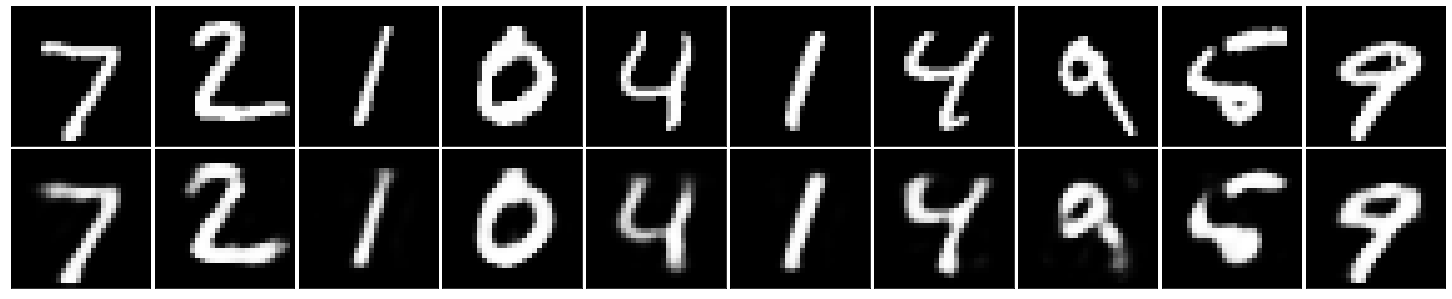

In [8]:
# figureの準備 = 2行,10列
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

# Testデータから10個画像を取得
in_imgs   = mnist.test.images[:10]

# まだ、上で作成した session は閉じていない
# encoded = 隠れ層のデータ
# decoded = 出力層のデータ
# 入力に、Testデータを入れた時の Encode結果を、下記で取得している。
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

# 20個の画像データ[in_imgs, reconstructed]を、一つずつ表示する
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [9]:
sess.close()

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.